# Load data

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Training dataset creation

### Output data

In [3]:
Qstar = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_star.zarr", engine="zarr", chunks={}
)
Qstar

<xarray.Dataset> Size: 14GB
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

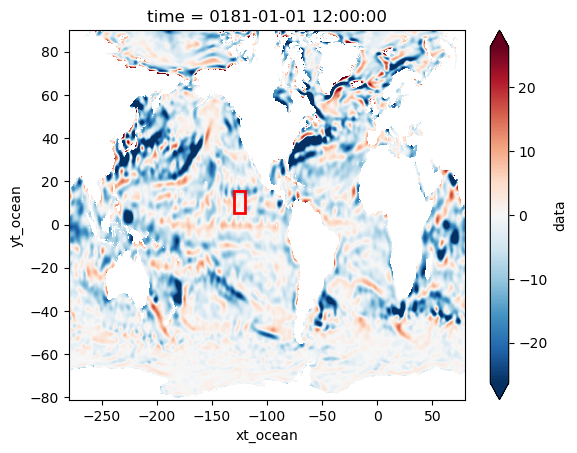

In [4]:
Qstar.data.isel(time=0).plot(robust=True)

lat_min, lat_max = 5.54134386, 15.36255392  # Replace with your actual values
lon_min, lon_max = -129.95, -119.95  # Replace with your actual values

# Draw the box on the plot
plt.gca().add_patch(
    plt.Rectangle(
        (lon_min, lat_min),  # (x, y) start point
        lon_max - lon_min,   # width
        lat_max - lat_min,   # height
        fill=False,          # don't fill the box
        edgecolor='red',     # color of the box
        linewidth=2
    )
)

# Show the plot
plt.show()

In [4]:
Qstar_sample = Qstar.isel(time=slice(0,365), xt_ocean=slice(1500,1600), yt_ocean=slice(1300,1400))
Qstar_sample

<xarray.Dataset> Size: 15MB
Dimensions:   (time: 365, yt_ocean: 100, xt_ocean: 100)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean  (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>

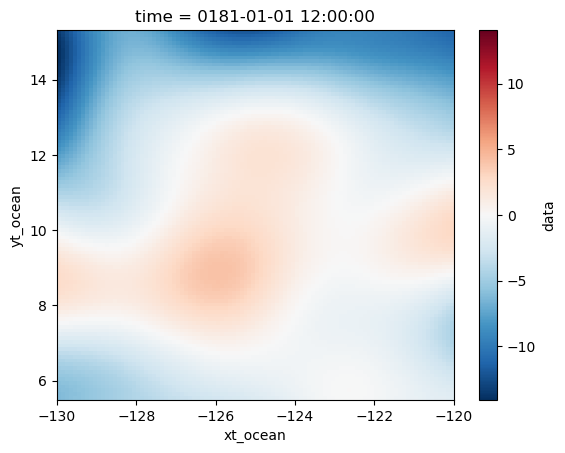

In [6]:
Qstar_sample.data.isel(time=0).plot()

In [5]:
Qstar_NN = Qstar_sample.isel(time=0) 
Qstar_NN

<xarray.Dataset> Size: 42kB
Dimensions:   (yt_ocean: 100, xt_ocean: 100)
Coordinates:
    time      object 8B 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean  (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    data      (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>

### Input data

In [6]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

print("Filtering model")
ds_out = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')

ds_lowRes = ds_out.isel(time=slice(0,365), xt_ocean=slice(1500,1600), yt_ocean=slice(1300,1400))
ds_lowRes

Filtering model


<xarray.Dataset> Size: 161MB
Dimensions:       (time: 365, xt_ocean: 100, yt_ocean: 100)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean      (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [7]:
ds_lowRes_NN = ds_lowRes.isel(time=0)
ds_lowRes_NN

<xarray.Dataset> Size: 442kB
Dimensions:       (xt_ocean: 100, yt_ocean: 100)
Coordinates:
    time          object 8B 0181-01-01 12:00:00
  * xt_ocean      (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean      (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    slp           (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    wind          (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_ocean       (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_ocean       (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_relative    (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_relative    (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [8]:
u_rel = ds_lowRes_NN.u_relative
v_rel = ds_lowRes_NN.v_relative
sst = ds_lowRes_NN.surface_temp
t_ref = ds_lowRes_NN.t_ref

## NN architecture setup

In [9]:
class SGS_HF(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 8)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(8, 4)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(4, 1)
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x
 
model = SGS_HF()
print(model)

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [12]:
print(model)

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [13]:
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [103]:
n_epochs = 5
batch_size = 3

for epoch in range(n_epochs):    
    for i in range(0, 30, batch_size): 
        
        # Prepare batch data
        x_urel = torch.tensor(u_rel.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        x_vrel = torch.tensor(v_rel.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        x_sst = torch.tensor(sst.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        x_tref = torch.tensor(t_ref.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        
        # Concatenate features along the feature dimension (dim=1)
        Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)
        
        # Forward pass, predictions made for this loop
        y_pred = model(Xbatch) 
        
        # Prepare target data
        ybatch = torch.tensor(Qstar_NN.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).data.values, dtype=torch.float32)
        
        # Compute loss
        loss = loss_fn(y_pred.squeeze(), ybatch)  

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients 
        optimizer.step()       # Update model parameters
        
        print(f'Batch {i // batch_size}, loss {loss.item()}')
        
    print(f'Finished epoch {epoch}, latest loss {loss.item()}')


Batch 0, loss 4234.7138671875
Batch 1, loss 4159.33447265625
Batch 2, loss 4052.80029296875
Batch 3, loss 3956.967529296875
Batch 4, loss 3880.973876953125
Batch 5, loss 3777.51611328125
Batch 6, loss 3696.1318359375
Batch 7, loss 3650.11328125
Batch 8, loss 3536.096923828125
Batch 9, loss 3426.000732421875
Batch 10, loss 3352.824951171875
Finished epoch 0, latest loss 3352.824951171875
Batch 0, loss 3330.222900390625
Batch 1, loss 3273.27392578125
Batch 2, loss 3188.6923828125
Batch 3, loss 3113.567626953125
Batch 4, loss 3056.091796875
Batch 5, loss 2974.180419921875
Batch 6, loss 2911.63916015625
Batch 7, loss 2880.276123046875
Batch 8, loss 2788.30810546875
Batch 9, loss 2699.5810546875
Batch 10, loss 2643.420654296875
Finished epoch 1, latest loss 2643.420654296875
Batch 0, loss 2631.468505859375
Batch 1, loss 2589.223876953125
Batch 2, loss 2522.219970703125
Batch 3, loss 2463.4453125
Batch 4, loss 2420.0966796875
Batch 5, loss 2354.81591796875
Batch 6, loss 2306.69580078125
Batc

In [16]:
torch.save(model.state_dict(), 'gs://leap-persistent/panalluri/airSeaTrial1NN.pth')

In [105]:
torch.save(model, 'gs://leap-persistent/panalluri/airSeaTrial1NN_wholeModel.pth')

### NN training losses

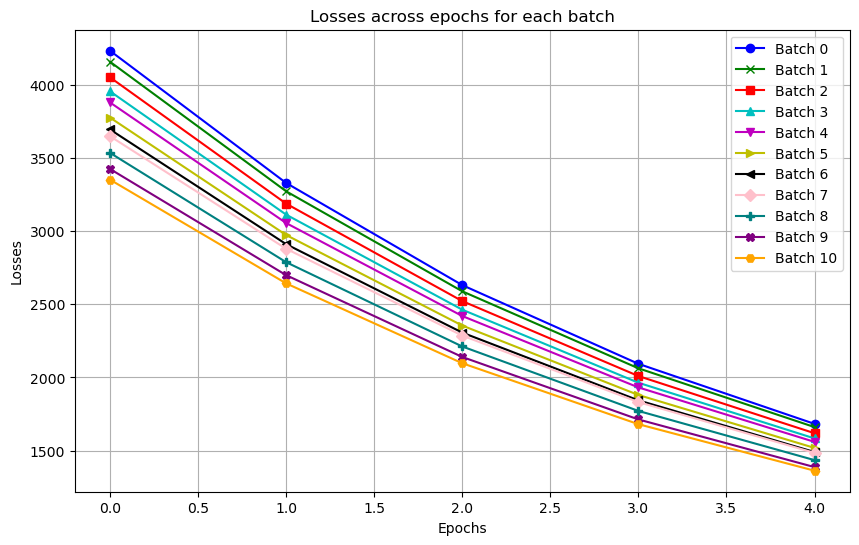

In [31]:
# Example data for multiple lines
epochs = [0, 1, 2, 3, 4]
batch_0_losses = [4234.71, 3330.22, 2631.47, 2093.28, 1682.40]
batch_1_losses = [4159.33, 3273.27, 2589.22, 2062.56, 1660.47]
batch_2_losses = [4052.80, 3188.69, 2522.22, 2009.62, 1618.49]
batch_3_losses = [3956.97, 3113.57, 2463.45, 1963.90, 1582.83]
batch_4_losses = [3880.97, 3056.09, 2420.10, 1931.83, 1559.30]
batch_5_losses = [3777.52, 2974.18, 2354.82, 1880.04, 1517.90]
batch_6_losses = [3696.13, 2911.64, 2306.70, 1843.44, 1490.03]
batch_7_losses = [3650.11, 2880.28, 2286.25, 1831.45, 1484.16]
batch_8_losses = [3536.10, 2788.31, 2211.74, 1770.96, 1434.52]
batch_9_losses = [3426.00, 2699.58, 2140.00, 1712.79, 1386.80]
batch_10_losses = [3352.82, 2643.42, 2097.16, 1680.33, 1362.10]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(epochs, batch_0_losses, marker='o', color='b', label='Batch 0')  
plt.plot(epochs, batch_1_losses, marker='x', color='g', label='Batch 1')  
plt.plot(epochs, batch_2_losses, marker='s', color='r', label='Batch 2') 
plt.plot(epochs, batch_3_losses, marker='^', color='c', label='Batch 3')  
plt.plot(epochs, batch_4_losses, marker='v', color='m', label='Batch 4')  
plt.plot(epochs, batch_5_losses, marker='>', color='y', label='Batch 5') 
plt.plot(epochs, batch_6_losses, marker='<', color='k', label='Batch 6')  
plt.plot(epochs, batch_7_losses, marker='D', color='pink', label='Batch 7')  
plt.plot(epochs, batch_8_losses, marker='P', color='teal', label='Batch 8') 
plt.plot(epochs, batch_9_losses, marker='X', color='purple', label='Batch 9')  
plt.plot(epochs, batch_10_losses, marker='H', color='orange', label='Batch 10')  

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses across epochs for each batch')
plt.legend()  # Add legend to distinguish lines
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()


## Evaluate NN performance

In [10]:
model = SGS_HF()  # Recreate the model instance
model.load_state_dict(torch.load('leap-persistent/panalluri/airSeaTrial1NN.pth'))
model.eval()  # Set the model to evaluation mode

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)

### Trial 1

In [11]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_NN.isel(xt_ocean=slice(30, 33), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).data.values, dtype=torch.float32)
y_true

tensor([-3.2372, -3.0888, -2.9323, -3.1581, -3.0000, -2.8353, -3.0819, -2.9146,
        -2.7423])

In [12]:
# input info for NN
x_urel = torch.tensor(u_rel.isel(xt_ocean=slice(30, 33), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel.isel(xt_ocean=slice(30, 33), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_sst = torch.tensor(sst.isel(xt_ocean=slice(30, 33), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref.isel(xt_ocean=slice(30, 33), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)

In [13]:
Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1) #stack inputs to NN

In [14]:
with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

In [15]:
# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1585.20654296875
Mean Absolute Error: 39.81439971923828
R-squared: -70905.4609375


#### Plot comparison

In [17]:
import matplotlib.gridspec as gridspec

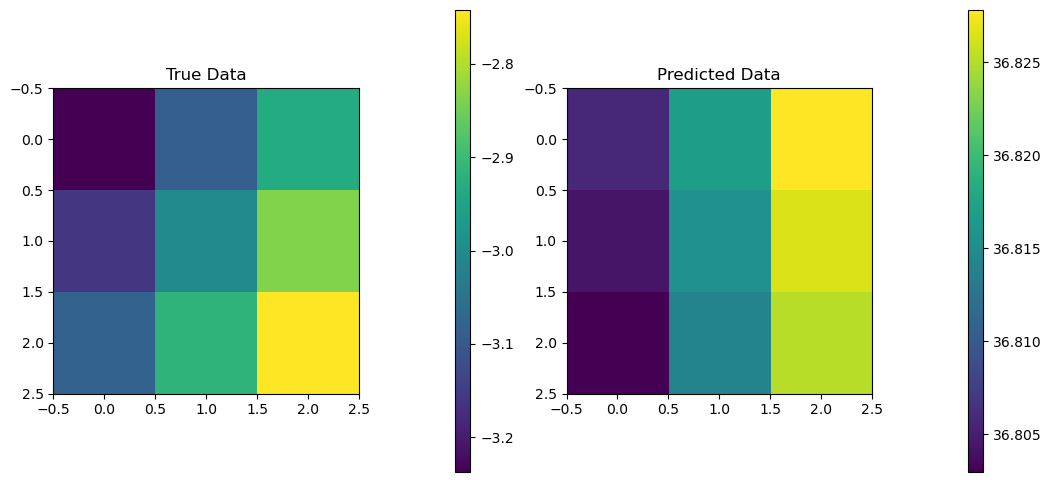

In [18]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Trial 2

In [19]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_NN.isel(xt_ocean=slice(33, 36), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).data.values, dtype=torch.float32)
y_true

# input info for NN
x_urel = torch.tensor(u_rel.isel(xt_ocean=slice(33, 36), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel.isel(xt_ocean=slice(33, 36), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_sst = torch.tensor(sst.isel(xt_ocean=slice(33, 36), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref.isel(xt_ocean=slice(33, 36), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)

Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1) #stack inputs to NN

with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1565.40771484375
Mean Absolute Error: 39.56493377685547
R-squared: -59543.015625


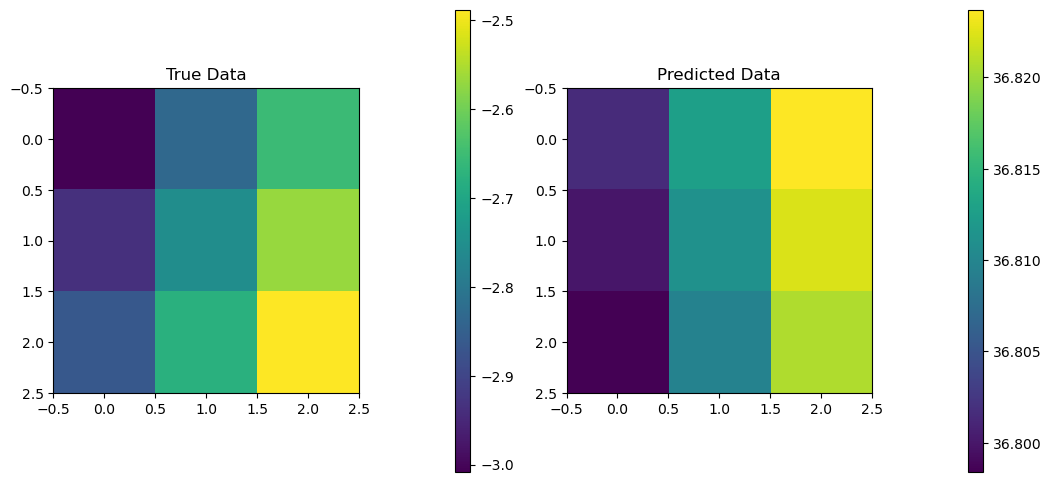

In [20]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Trial 3

In [21]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_NN.isel(xt_ocean=slice(36, 39), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).data.values, dtype=torch.float32)
y_true

# input info for NN
x_urel = torch.tensor(u_rel.isel(xt_ocean=slice(36, 39), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel.isel(xt_ocean=slice(36, 39), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_sst = torch.tensor(sst.isel(xt_ocean=slice(36, 39), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref.isel(xt_ocean=slice(36, 39), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)

Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1) #stack inputs to NN

with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1547.64794921875
Mean Absolute Error: 39.33982467651367
R-squared: -53907.53515625


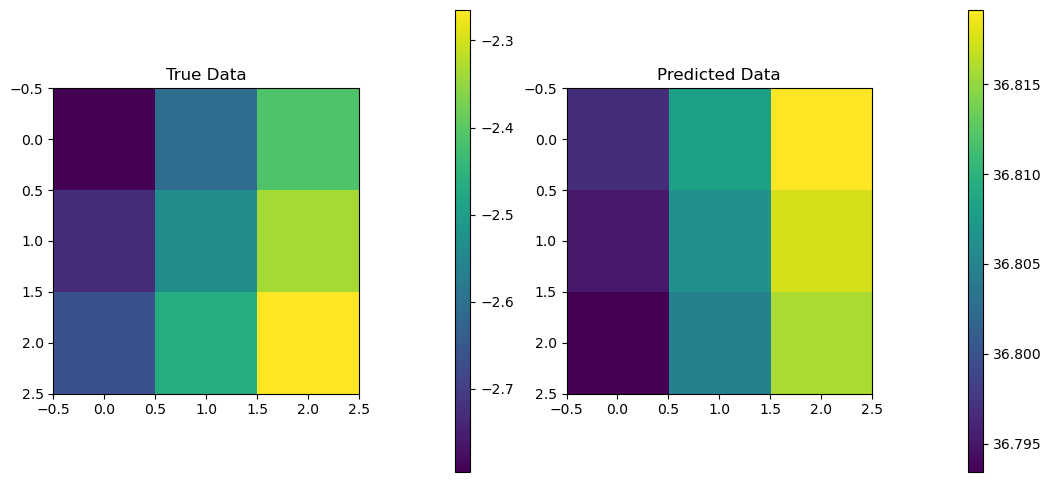

In [22]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
